In [1]:
import pandas as pd
import numpy as np
import anndata as ad
import os
import sys
from collections import Counter
import gget
import scipy
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfTransformer
import itertools

import scanpy as sc
import scanpy.external as sce
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
from importlib import reload

# local imports
# sys.path.append("../")
import utils as ut

In [2]:
def min_max(v):
    return (v - v.min()) / (v.max() - v.min())

# load the gene table file 

In [3]:
gtf_path = "/nfs/turbo/umms-indikar/shared/projects/HSC/data/results/HSC/references/geneTable.csv"

gdf = pd.read_csv(gtf_path)
print(f"{gdf.shape=}")
gdf.head()

/tmp/ipykernel_2065479/2587861779.py:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  gdf = pd.read_csv(gtf_path)


gdf.shape=(3371244, 26)


,Chromosome,Source,Feature,Start,End,Score,Strand,Frame,gene_id,gene_version,...,transcript_source,transcript_biotype,tag,ccds_id,exon_number,exon_id,exon_version,protein_id,protein_version,transcript_support_level
0,1,ensembl_havana,gene,1471764,1497848,.,+,.,ENSG00000160072,20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,ensembl_havana,transcript,1471764,1497848,.,+,.,ENSG00000160072,20,...,ensembl_havana,protein_coding,basic,CCDS30,NaN,NaN,NaN,NaN,NaN,NaN
2,1,ensembl_havana,exon,1471764,1472089,.,+,.,ENSG00000160072,20,...,ensembl_havana,protein_coding,basic,CCDS30,1.0,ENSE00003889014,1.0,NaN,NaN,NaN
3,1,ensembl_havana,CDS,1471884,1472089,.,+,0,ENSG00000160072,20,...,ensembl_havana,protein_coding,basic,CCDS30,1.0,NaN,NaN,ENSP00000500094,1.0,NaN
4,1,ensembl_havana,start_codon,1471884,1471887,.,+,0,ENSG00000160072,20,...,ensembl_havana,protein_coding,basic,CCDS30,1.0,NaN,NaN,NaN,NaN,NaN


# Load our data

In [4]:
fpath = "/nfs/turbo/umms-indikar/shared/projects/HSC/data/results/HSC/scanpy/anndata.tabula.h5ad"

adata = sc.read_h5ad(fpath)
adata

AnnData object with n_obs × n_vars = 35830 × 14599
    obs: 'cluster_name', 'set', 'UMAP 1', 'UMAP 2', 'organ_tissue', 'celltype'
    var: 'gene_id', 'gene_symbol', 'is_fb_marker', 'is_hsc_marker'
    uns: 'log1p'
    layers: 'combat_corrected', 'log_tpm', 'raw_counts'

In [5]:
adata.var_names_make_unique()

# annotate all labels
adata.obs['group'] = np.where(adata.obs['cluster_name'].isna(), "C5", adata.obs['cluster_name'])
adata.obs['group'] = np.where(adata.obs['celltype'] == 'HSC', "C6", adata.obs['group'])

# prepare data

In [6]:
# prepare sample
pdf = ut.get_stacked_cell_data(adata, genes=None)

# compute the PCA
n_comps = 30
sc.tl.pca(pdf, 
          n_comps=n_comps, 
          use_highly_variable=False)

# compute the UMAP
knn = 31
knn_metric = 'euclidean'
sc.pp.neighbors(pdf, 
                n_neighbors=knn, 
                metric=knn_metric, 
                n_pcs=n_comps)

sc.tl.umap(pdf, n_components=n_comps)

# subset out the important cells
our = pdf[pdf.obs['set'] == 'our_data']
print(our)
print()
hsc = pdf[pdf.obs['group'] == 'C6']
print(hsc)
print()
fb = pdf[pdf.obs['group'] == 'C5']
print(fb)

2024-04-18 09:09:09.309615: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-18 09:09:20.032022: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-18 09:10:05.154877: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/cstansbu/miniconda3/lib
2024-04-18 09:10:05.157061: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plug

RuntimeError: module compiled against API version 0xf but this version of numpy is 0xe

View of AnnData object with n_obs × n_vars = 8484 × 14599
    obs: 'cluster_name', 'set', 'UMAP 1', 'UMAP 2', 'organ_tissue', 'celltype', 'group'
    var: 'gene_id', 'gene_symbol', 'is_fb_marker', 'is_hsc_marker'
    uns: 'log1p', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'combat_corrected', 'log_tpm', 'raw_counts'
    obsp: 'distances', 'connectivities'

View of AnnData object with n_obs × n_vars = 760 × 14599
    obs: 'cluster_name', 'set', 'UMAP 1', 'UMAP 2', 'organ_tissue', 'celltype', 'group'
    var: 'gene_id', 'gene_symbol', 'is_fb_marker', 'is_hsc_marker'
    uns: 'log1p', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'combat_corrected', 'log_tpm', 'raw_counts'
    obsp: 'distances', 'connectivities'

View of AnnData object with n_obs × n_vars = 7724 × 14599
    obs: 'cluster_name', 'set', 'UMAP 1', 'UMAP 2', 'organ_tissue', 'celltype', 'group'
    var: 'gene_id', 'gene_symbol', 'is_fb_marker', 'is_hs

# get closest cells

In [7]:
def distance_to(X, Y, metric='euclidean'):
    """A function to compute pariwise distances between X and Y.
    Returns agg stats for distance along X observations """
    D = scipy.spatial.distance.cdist(X, Y, metric=metric)
    
    dists = pd.DataFrame({
        'mean_dist' : min_max(D.mean(axis=1)),
        'std_dist' : min_max(D.std(axis=1)),
        'min_dist' : min_max(D.min(axis=1)),
        'max_dist' : min_max(D.max(axis=1)),
    })
    return dists


X = our.X
Y = hsc.X
dists = distance_to(X, Y)
dists['index'] = our.obs_names
dists = dists.set_index('index')
dists.head()

,mean_dist,std_dist,min_dist,max_dist
index,,,,
AAACCCAAGGTTACCT,0.347283,0.330633,0.437811,0.275580
AAACCCAAGTTGAAGT,0.315598,0.342285,0.410768,0.253787
AAACCCAAGTTGTCGT,0.234936,0.496165,0.304286,0.154408
AAACCCACAGAAGCGT,0.249724,0.500802,0.312612,0.167023
AAACCCACAGGAGGTT,0.389237,0.179775,0.515172,0.371666


# analyze

In [8]:
cdf = our.obs.copy()

cdf = pd.merge(cdf, dists, 
               how='left',
               left_index=True,
               right_index=True,)

cdf.head()

,cluster_name,set,UMAP 1,UMAP 2,organ_tissue,celltype,group,mean_dist,std_dist,min_dist,max_dist
AAACCCAAGGTTACCT,C1,our_data,0.109329,-3.306156,NaN,NaN,C1,0.347283,0.330633,0.437811,0.275580
AAACCCAAGTTGAAGT,C1,our_data,0.709752,-5.965948,NaN,NaN,C1,0.315598,0.342285,0.410768,0.253787
AAACCCAAGTTGTCGT,C2,our_data,1.080425,10.928792,NaN,NaN,C2,0.234936,0.496165,0.304286,0.154408
AAACCCACAGAAGCGT,C2,our_data,-0.343613,12.158470,NaN,NaN,C2,0.249724,0.500802,0.312612,0.167023
AAACCCACAGGAGGTT,C1,our_data,-3.001347,-3.411731,NaN,NaN,C1,0.389237,0.179775,0.515172,0.371666


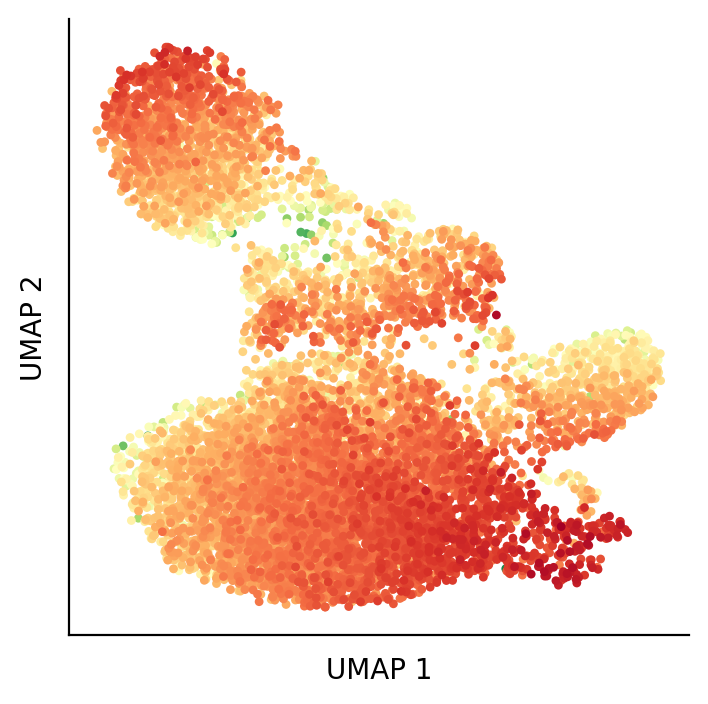

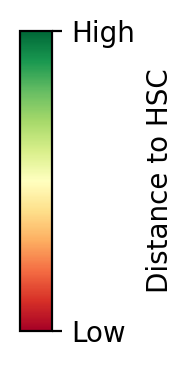

In [9]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 4

cmap = 'RdYlGn'
cdf = cdf.sort_values(by='mean_dist', ascending=False)

sns.scatterplot(data=cdf, 
                x='UMAP 1',
                y='UMAP 2',
                hue='mean_dist',
                ec='none',
                s=10,
                legend=False,
                palette=cmap)

# sns.move_legend(plt.gca(),
#                 title="",
#                 loc='upper right',
#                 bbox_to_anchor=(1.3, 1))

_ = plt.yticks([])
_ = plt.xticks([])
sns.despine()


ut.makeColorbar(cmap, 0.2, 2.5, 'Distance to HSC', 'vertical', ['Low', 'High'])

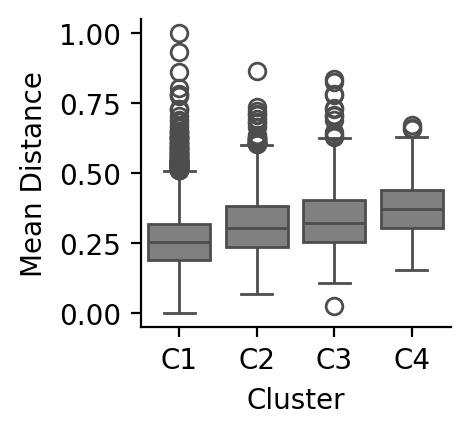

In [10]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 2, 2

sns.boxplot(data=cdf,
            x='cluster_name',
            y='mean_dist',
            color='grey')

plt.ylabel('Mean Distance')
plt.xlabel('Cluster')
sns.despine()

In [11]:
cdf = cdf.sort_values(by='mean_dist', ascending=True)
cdf.head()

,cluster_name,set,UMAP 1,UMAP 2,organ_tissue,celltype,group,mean_dist,std_dist,min_dist,max_dist
CACTAAGAGCGTATGG,C1,our_data,8.336246,-4.881739,NaN,NaN,C1,0.000000,0.926127,0.000000,0.021101
TTCACGCCAGCTGTTA,C3,our_data,6.591168,3.984687,NaN,NaN,C3,0.025485,0.828528,0.046915,0.020930
GATTCGATCTACGCGG,C1,our_data,7.383643,-5.179481,NaN,NaN,C1,0.027299,0.757234,0.075316,0.000000
TAGACCAGTGCCGTTG,C1,our_data,8.505472,-5.458646,NaN,NaN,C1,0.027764,0.840189,0.048345,0.026909
ATCGGATGTTCAAAGA,C1,our_data,7.527978,-6.871134,NaN,NaN,C1,0.028823,0.820121,0.055887,0.018755


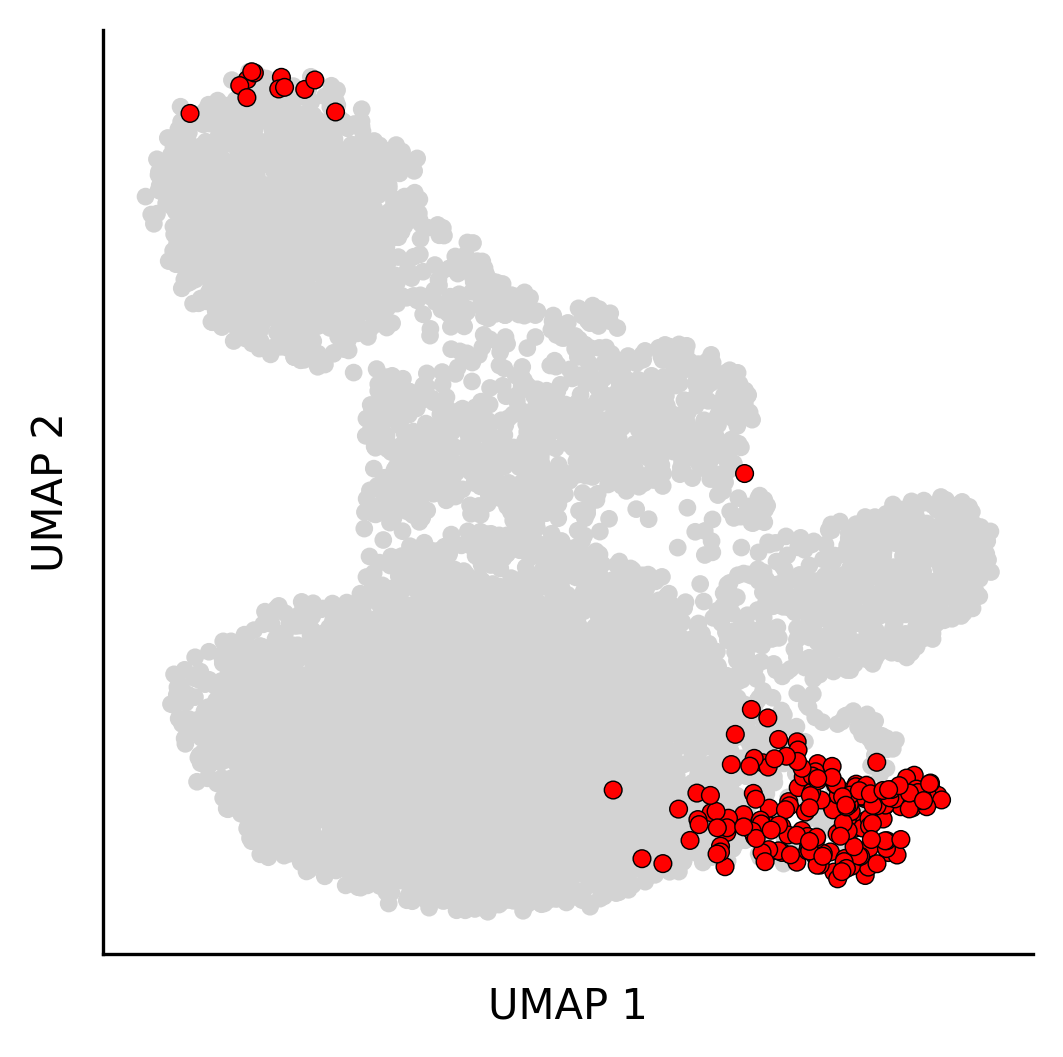

In [12]:
# Who are they?
n_top  = 200
# sort_by = 'min_dist'
sort_by = 'min_dist'
cdf = cdf.sort_values(by=sort_by, ascending=True)

our_idx = cdf.head(n_top).index

close = our[our_idx, ]


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 4

size=3

sns.scatterplot(data=close.obs,
                x='UMAP 1',
                y='UMAP 2',
                ec='k',
                color='r',
                size=size,
                zorder=3)


sns.scatterplot(data=our.obs,
                x='UMAP 1',
                y='UMAP 2',
                color='lightgrey',
                # linewidths=0.1,
                size=size,
                ec='none',
                zorder=2)

plt.gca().legend().remove()

plt.yticks([])
plt.xticks([])
sns.despine()

# build single-cell plot

In [13]:
close.var.head()

,gene_id,gene_symbol,is_fb_marker,is_hsc_marker
gene_name,,,,
ATAD3B,ENSG00000160072,ATAD3B,False,False
SKI,ENSG00000157933,SKI,False,False
PEX14,ENSG00000142655,PEX14,False,False
PLCH2,ENSG00000149527,PLCH2,False,False
SPSB1,ENSG00000171621,SPSB1,False,False


In [14]:
gdf.head()

,Chromosome,Source,Feature,Start,End,Score,Strand,Frame,gene_id,gene_version,...,transcript_source,transcript_biotype,tag,ccds_id,exon_number,exon_id,exon_version,protein_id,protein_version,transcript_support_level
0,1,ensembl_havana,gene,1471764,1497848,.,+,.,ENSG00000160072,20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,ensembl_havana,transcript,1471764,1497848,.,+,.,ENSG00000160072,20,...,ensembl_havana,protein_coding,basic,CCDS30,NaN,NaN,NaN,NaN,NaN,NaN
2,1,ensembl_havana,exon,1471764,1472089,.,+,.,ENSG00000160072,20,...,ensembl_havana,protein_coding,basic,CCDS30,1.0,ENSE00003889014,1.0,NaN,NaN,NaN
3,1,ensembl_havana,CDS,1471884,1472089,.,+,0,ENSG00000160072,20,...,ensembl_havana,protein_coding,basic,CCDS30,1.0,NaN,NaN,ENSP00000500094,1.0,NaN
4,1,ensembl_havana,start_codon,1471884,1471887,.,+,0,ENSG00000160072,20,...,ensembl_havana,protein_coding,basic,CCDS30,1.0,NaN,NaN,NaN,NaN,NaN


In [15]:
# extract the HSC marker genes
gene_idx = close.var[close.var['is_hsc_marker']]['gene_id'].values
print(f"{len(gene_idx)=}")

genes = gdf[gdf['gene_id'].isin(gene_idx)] 
genes = genes[genes['Feature'] == 'gene']
print(f"{genes.shape=}")

genes['Chromosome'].value_counts().head()

len(gene_idx)=72
genes.shape=(72, 26)


1     13
3      6
4      6
10     5
11     5
Name: Chromosome, dtype: int64

# Chromosome 1 has the most HSC genes!

       gene_name Chromosome      Start
71871        MPL          1   43337817
271271      TAL1          1   47216289
285473      GFI1          1   92473042
257315    NOTCH2          1  119911552
249757     TXNIP          1  145992434


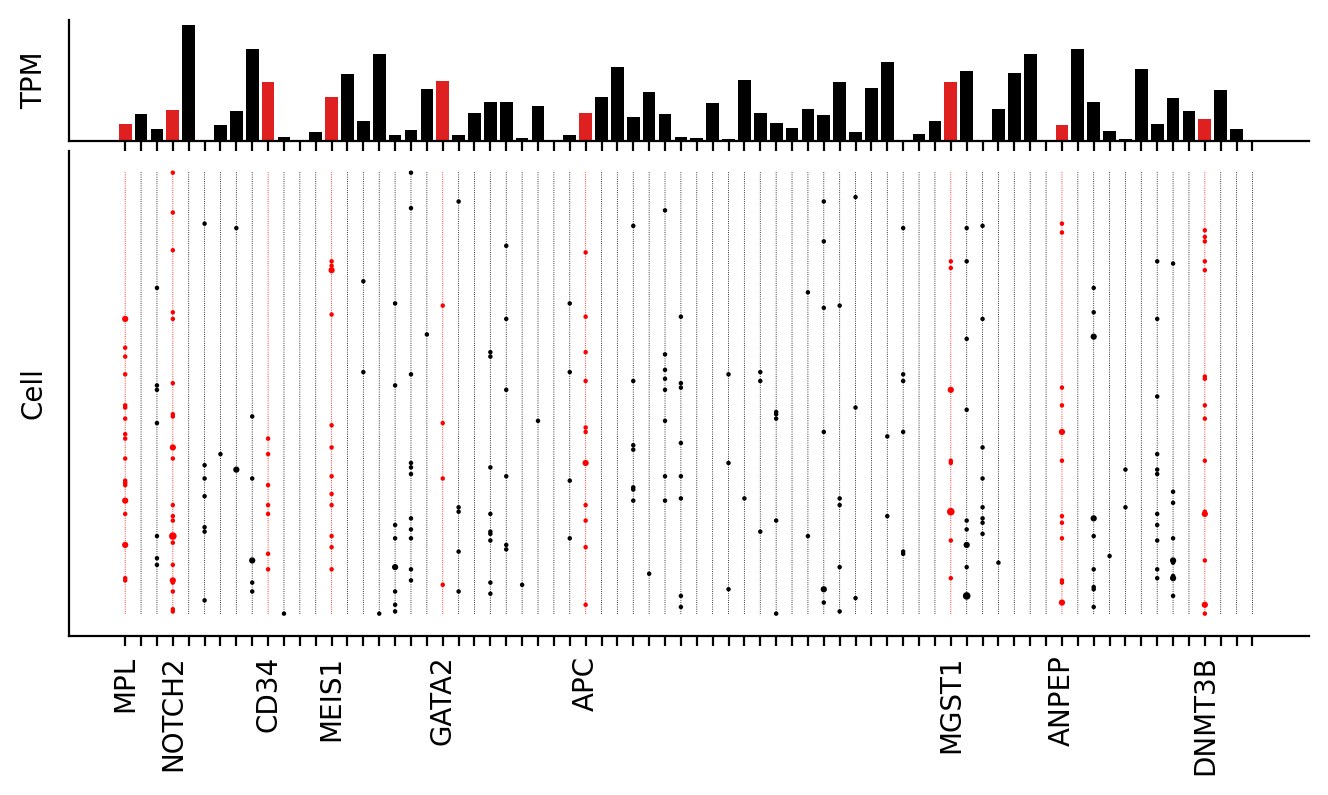

In [16]:
# sort genes by position on chromosome 1
genes = genes.sort_values(by=['Chromosome', 'Start'])
print(genes[['gene_name', 'Chromosome', 'Start']].head())

# extract our cells over those genes
cells = close[:, genes['gene_name'].values].to_df(layer='raw_counts')
cells = cells.reset_index(drop=False)
cells = pd.melt(cells, id_vars='index')

cells.head()

show_labels = [
    'MPL',
    'NOTCH2',
    'MGST1',
    'DNMT3B',
    'CD34',
    'GATA2',
    'ANPEP',
    'MEIS1',
    'APC',
]

cells['color'] = np.where(cells['gene_name'].isin(show_labels), 'r', 'k')


plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 8, 4


# plot them
sns.scatterplot(data=cells,
                x='gene_name',
                y='index',
                marker=".",
                # s=10,
                ec='none',
                size='value',
                hue='color',
                legend=False,
                palette=['r', 'k'],
                sizes=(0.5, 30),)


plt.yticks([], [])
plt.xlabel("")
plt.ylabel("Cell")

new_ticks = []
tick_pos = plt.xticks()[0]
for tick in plt.xticks()[1]:
    ticklabel = tick.get_text()

    new_tick_label = ""

    if ticklabel in show_labels:
        new_tick_label = tick.get_text()

    new_ticks.append(new_tick_label)

ax = plt.gca()

ax.set_xticks(tick_pos, new_ticks)
ax.tick_params(axis='x', rotation=90)

"""Add in the reference signature """


ax_divider = make_axes_locatable(ax)
ax2 = ax_divider.append_axes("top", size="25%", pad="2%")


ref_cells = hsc[:, genes['gene_name'].values].to_df(layer='log_tpm')
ref_cells = pd.DataFrame(ref_cells.mean(axis=0)).reset_index(drop=False)
ref_cells.columns = ['gene_name', 'mean_exp']
ref_cells['color'] = np.where(ref_cells['gene_name'].isin(show_labels), 'r', 'k')

sns.barplot(data=ref_cells,
            x='gene_name',
            y='mean_exp',
            hue='color',
            palette=['r', 'k'],
            legend=False,
            ax=ax2)

ax2.set_xlabel("")
ax2.set_ylabel("TPM")
ax2.set_yticks([])
ax2.sharex(ax)
ax2.tick_params(axis='x', labelsize=1, labelcolor='w')

sns.despine()



In [17]:
cells.groupby('gene_name')['value'].sum().sort_values(ascending=False).head(15)

gene_name
NOTCH2    25.0
MPL       21.0
DNMT3B    17.0
ANPEP     14.0
MEIS1     13.0
APC       12.0
NFE2      12.0
ADGRG1    11.0
MGST1     11.0
MYADM     11.0
CD33      11.0
CDCP1     11.0
FGD5       9.0
PROM1      9.0
ABCB1      8.0
Name: value, dtype: float64

# some QC on the barcodes

In [37]:
# Who are they?
n_top  = 1000
sort_by = 'mean_dist'
cdf = cdf.sort_values(by=sort_by, ascending=True)


our_idx = cdf.head(n_top).index

close = our[our_idx, ]
close

View of AnnData object with n_obs × n_vars = 1000 × 14599
    obs: 'cluster_name', 'set', 'UMAP 1', 'UMAP 2', 'organ_tissue', 'celltype', 'group'
    var: 'gene_id', 'gene_symbol', 'is_fb_marker', 'is_hsc_marker'
    uns: 'log1p', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'combat_corrected', 'log_tpm', 'raw_counts'
    obsp: 'distances', 'connectivities'

# write these cells to file

In [38]:
truseq = "ACACTCTTTCCCTACACGACGCTCTTCCGATCT"

outpath = f"../{n_top}_closest.fasta"

# remove if exists
if os.path.exists(outpath):
  os.remove(outpath)

with open(outpath, 'w') as outfile:
    for barcode in our_idx:
        new_read_name = f"{barcode}:{n_top}_closestby_{sort_by}"
        bc_seq = f"{truseq}{barcode}"    
        print(f">{new_read_name}", file=outfile)
        print(f"{bc_seq}", file=outfile)

print('done')

done


In [ ]:
break

# analysis on closest cells

In [ ]:
our.obs['is_close'] = our.obs.index.isin(our_idx)

our.obs['close_cat'] = np.where(our.obs['is_close'], 'Close', 'Far')
our.obs['close_cat'] = our.obs['close_cat'].astype('category')

sc.pp.calculate_qc_metrics(our, layer='raw_counts', inplace=True)
our.obs.head()

In [ ]:
break

In [ ]:
plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = 4, 3
sc.pl.highest_expr_genes(our, n_top=10, )

In [ ]:
our.obs.head()

In [ ]:
plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = 4, 3

plot_var = 'n_genes_by_counts'

sns.histplot(data=our.obs, 
             x=plot_var,
             bins=31,
             hue='is_close')

plt.title("Genes per Cell")

In [ ]:
plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = 4, 3

plot_var = 'total_counts'

sns.histplot(data=our.obs, 
             x=plot_var,
             bins=31,
             hue='is_close')

plt.title("Reads per Cell")

# DEG of closest cells

In [ ]:
sc.tl.rank_genes_groups(our, 
                        groupby='close_cat',
                        method='wilcoxon',
                        corr_method='benjamini-hochberg')

deg = sc.get.rank_genes_groups_df(our, group=None)

deg.head()

In [ ]:
n_genes = 10
lft = 1
alpha = 0.01

    
sig = deg[deg['logfoldchanges'] > lft]
sig = sig[sig['pvals_adj'] <= alpha]

# filter out predicted genes
sig = sig[~sig['names'].str.startswith("Gm")]
sig = sig[~sig['names'].str.endswith("Rik")]

sig = sig.sort_values(by=['group', 'logfoldchanges'], ascending=[False, False])

res = []

for cluster, group in sig.groupby('group'):
    group = group.head(n_genes)
    genes = group['names'].to_list()
    print(cluster, genes)

# quick GSEA

In [ ]:
n_query = 50
lft = 0.5
alpha = 0.01
    
sig = deg[deg['logfoldchanges'] > lft]
sig = sig[sig['group'] == 'Close']
sig = sig[sig['pvals_adj'] <= alpha]

# filter out predicted genes
sig = sig[~sig['names'].str.startswith("Gm")]
sig = sig[~sig['names'].str.endswith("Rik")]

query = sig['names'].head(n_query).to_list()
print(query)

edf = gget.enrichr(query, database='ontology')
cols = [
    'path_name',
    'adj_p_val',
    'overlapping_genes',
]
edf[cols].head(15)


In [ ]:
break